In [57]:
import rasterio
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import FancyArrowPatch, ConnectionPatch
from matplotlib.ticker import MaxNLocator, FuncFormatter

from rasterio.plot import show
from rasterio.merge import merge

from pathlib import Path
import os
import sys
import glob

# Get the parent directory of the current file
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)
# Import functions from functions.py
from functions import height_to_slopes, slopes_to_height
from WFC import WaveFunctionCollapse

plt.rcParams["font.family"] = "Times New Roman"



In [37]:

# Folder containing HGT files
hgt_folder = Path("/Users/parsa/Daneshgah/Arshad/Thesis/datasets/SRTM_IRAN/data/")

# List of all HGT files in the folder
hgt_files = sorted(hgt_folder.glob("*.hgt"))

# Specify the key areas (use filenames for identification)
key_areas_sorted = sorted(os.listdir("../data/"))
reindex = [0, 5, 6, 4, 3, 2, 1]
key_areas = []
for i in range(len(key_areas_sorted)):
    key_areas.append(key_areas_sorted[reindex[i]])

In [49]:
key_data['N26E057.hgt']['name']

('N26E057', '.hgt')

In [50]:
# Parameters for resampling and RoI
downsample_factor = 8  # Rescale factor for all datasets
roi_rows = slice(250, 350)  # Rows for RoI
roi_cols = slice(200, 300)  # Columns for RoI

# Step 1: Open and merge all HGT files
datasets = [rasterio.open(str(f)) for f in hgt_files]
big_elevation, big_transform = merge(datasets)

# Step 2: Downsample the merged dataset
downsampled_shape = (
    big_elevation.shape[0],
    big_elevation.shape[1] // downsample_factor,
    big_elevation.shape[2] // downsample_factor,
)
big_elevation_downsampled = big_elevation[
    :,
    ::downsample_factor,
    ::downsample_factor,
]
new_transform = big_transform * big_transform.scale(
    downsample_factor, downsample_factor
)

# Prepare key areas (RoIs from rescaled datasets)
key_data = {}
for key_name in key_areas:
    key_file = hgt_folder / key_name
    with rasterio.open(key_file) as src:
        # Read the full dataset and resample
        full_data = src.read(1)
        resampled = full_data[::downsample_factor, ::downsample_factor]

        # Extract RoI
        roi = resampled[roi_rows, roi_cols]

        # Adjust the transform for the resampled dataset
        resampled_transform = src.transform * src.transform.scale(
            downsample_factor, downsample_factor
        )

        # Adjust the transform for the specific RoI
        roi_transform = resampled_transform * resampled_transform.translation(
            roi_cols.start, roi_rows.start
        )

        # Calculate the bounds for the rectangle in the large plot
        x1, y1 = roi_transform * (0, 0)
        x2, y2 = roi_transform * (roi.shape[1], roi.shape[0])

        x_min = min(x1, x2)
        y_min = min(y1, y2)
        x_max = max(x1, x2)
        y_max = max(y1, y2)
        
        key_data[key_name] = {
            "data": roi,
            "transform": roi_transform,
            "bounds": [x_min, y_min, x_max, y_max],
        }


In [39]:
# Function to find intersection of line and rectangle
def intersect(p1, rect, line_vec):
    rect_min = np.array([rect[0], rect[1]])  # [xmin, ymin]
    rect_max = np.array([rect[2], rect[3]])  # [xmax, ymax]
    

    # Calculate intersection points with the rectangle edges
    # Check for all four edges of the rectangle (left, right, top, bottom)
    
    # Left edge (x = xmin)
    if line_vec[0] != 0:  # Prevent division by zero
        t = (rect_min[0] - p1[0]) / line_vec[0]
        if t >= 0:
            y_intersect = p1[1] + t * line_vec[1]
            if rect_min[1] <= y_intersect <= rect_max[1]:
                return [rect_min[0], y_intersect]

    # Right edge (x = xmax)
    if line_vec[0] != 0:
        t = (rect_max[0] - p1[0]) / line_vec[0]
        if t >= 0:
            y_intersect = p1[1] + t * line_vec[1]
            if rect_min[1] <= y_intersect <= rect_max[1]:
                return [rect_max[0], y_intersect]

    # Bottom edge (y = ymin)
    if line_vec[1] != 0:  # Prevent division by zero
        t = (rect_min[1] - p1[1]) / line_vec[1]
        if t >= 0:
            x_intersect = p1[0] + t * line_vec[0]
            if rect_min[0] <= x_intersect <= rect_max[0]:
                return [x_intersect, rect_min[1]]

    # Top edge (y = ymax)
    if line_vec[1] != 0:
        t = (rect_max[1] - p1[1]) / line_vec[1]
        if t >= 0:
            x_intersect = p1[0] + t * line_vec[0]
            if rect_min[0] <= x_intersect <= rect_max[0]:
                return [x_intersect, rect_max[1]]



# Plot kol

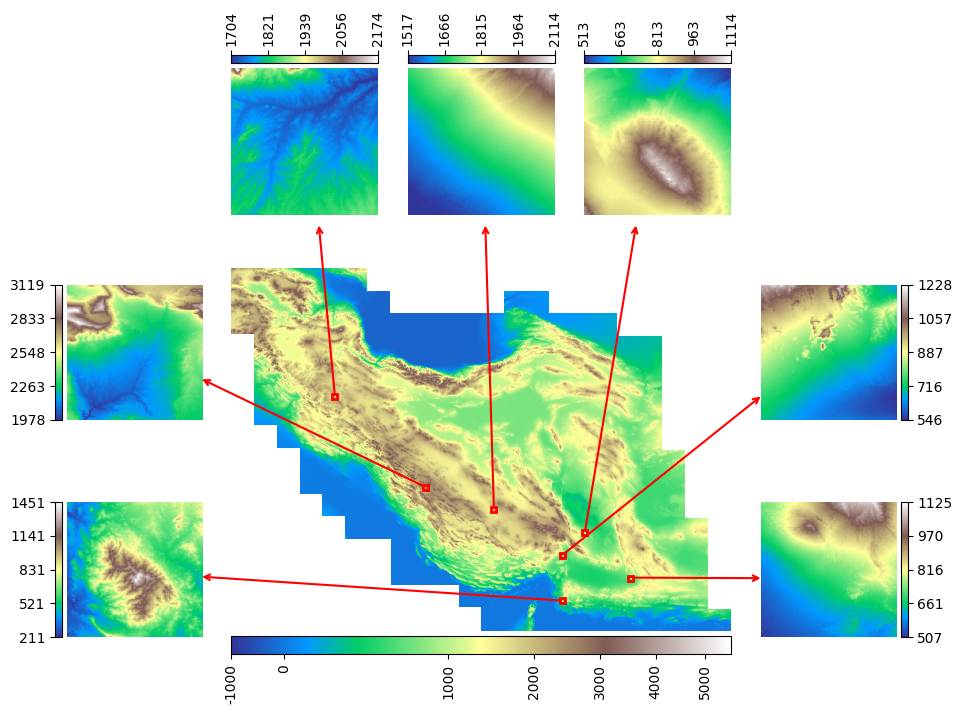

In [40]:
# Step 3: Plotting
mosaic = [[9, 2, 3, 4, 8],
          [1, 7, 7, 7, 5],
          [0, 7, 7, 7, 6]]
fig, axes = plt.subplot_mosaic(mosaic, figsize=(11,8))

for ax in axes:
    axes[ax].set_axis_off()

# Big plot (B)
mask = big_elevation_downsampled != -32768
masked_data = np.ma.masked_equal(big_elevation_downsampled, -32768)[0,...]

# Define the colormap with a color for the masked values (white)
cmap = plt.cm.terrain
cmap.set_bad(color='white')
norm = mcolors.PowerNorm(gamma=0.5)  # Adjust gamma as needed to emphasize higher values

ax_big = show(masked_data, transform=new_transform, ax=axes[7], cmap=cmap, norm=norm, title="")


# Highlight key areas with red rectangles
for key_name, key_info in key_data.items():
    bounds = key_info["bounds"]
    x_min, y_min = bounds[0:2]
    x_max, y_max = bounds[2:]
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor="red",
        facecolor="none",
    )
    ax_big.add_patch(rect)

# Individual key area plots
for ax_key, (key_name, key_info) in enumerate(key_data.items()):
    row, col = np.where(np.array(mosaic) == ax_key)
    
    show(key_info["data"], transform=key_info["transform"], ax=axes[ax_key], cmap="terrain")
    
for key, ax in axes.items():
    if len(ax.images) > 0:

        # Make the colorbar proportionate to the plot
        divider = make_axes_locatable(ax)
        if key in [0, 1]:
            pos = "left"
        elif key in [2,3,4]:
            pos = "top"
        elif key in [5,6]:
            pos = "right"
        elif key == 7:
            pos = "bottom"
        cax = divider.append_axes(pos, size="5%", pad=0.05)
        im = ax.images[0]
        cbar = plt.colorbar(im, cax=cax, orientation='vertical' if pos in ['left', 'right'] else 'horizontal')
        
        if key != 7:
            cbar.set_ticks(np.linspace(im.get_array().min(), im.get_array().max(), 5))
        
        # Adjust tick label rotation and alignment based on position
        if pos in ['left', 'right']:
            cbar.ax.tick_params(labelrotation=0)  # Horizontal ticks
            cbar.ax.yaxis.set_ticks_position('left' if pos == 'left' else 'right')  # Position ticks on left or right
            cbar.ax.yaxis.set_label_position('left' if pos == 'left' else 'right')  # Position colorbar label on left or right
        else:
            cbar.ax.tick_params(labelrotation=90)  # Vertical ticks
            cbar.ax.xaxis.set_ticks_position('bottom' if pos == 'bottom' else 'top')  # Position ticks on top or bottom
            cbar.ax.xaxis.set_label_position('bottom' if pos == 'bottom' else 'top')  # Position colorbar label on top or bottom

        # Format tick labels as integers
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{int(val)}'))
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{int(val)}'))

cons = []
# Add arrows connecting rectangles to individual subplots
for ax_key, (key_name, key_info) in enumerate(key_data.items()):
    # Get bounds of the key area's rectangle in the big plot
    bounds = key_info["bounds"]
    x_min, y_min = bounds[0:2]
    x_max, y_max = bounds[2:]
    rect_center = ((x_min + x_max) / 2, (y_min + y_max) / 2)

    # Get subplot position
    row, col = np.where(np.array(mosaic) == ax_key)
    subplot_ax = axes[ax_key]

    # Get center of the subplot (subplot in figure coordinates)
    subplot_bbox = subplot_ax.get_position(fig)
    subplot_center = subplot_bbox.x0 + subplot_bbox.width / 2, subplot_bbox.y0 + subplot_bbox.height / 2

    # Transform rect_center from data coordinates to figure coordinates
    rect_center_disp = ax_big.transData.transform(rect_center)

    # Transform subplot_center from figure coordinates to ax_big's data coordinates
    subplot_center_disp = fig.transFigure.transform(subplot_center)

    vector = subplot_center_disp - rect_center_disp
    vector = vector / np.linalg.norm(vector)
    
    start = intersect(rect_center, [x_min, y_min, x_max, y_max], vector)


    x_min_bbox = min(subplot_bbox.x0, subplot_bbox.x1)
    x_max_bbox = max(subplot_bbox.x0, subplot_bbox.x1)
    y_min_bbox = min(subplot_bbox.y0, subplot_bbox.y1)
    y_max_bbox = max(subplot_bbox.y0, subplot_bbox.y1)
    end = intersect(subplot_center, [x_min_bbox, y_min_bbox, x_max_bbox, y_max_bbox], -vector)

    # Create the connection (arrow) between the two transformed points
    con = ConnectionPatch(
        xyA=start, coordsA=ax_big.transData,  # Point in figure coordinates
        xyB=end, coordsB=fig.transFigure,  # Point in data coordinates in ax_big
        arrowstyle="->", color="red", lw=1.5
    )
    cons.append(con)


for con in cons:
    fig.add_artist(con)
    

    


# plot ship

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


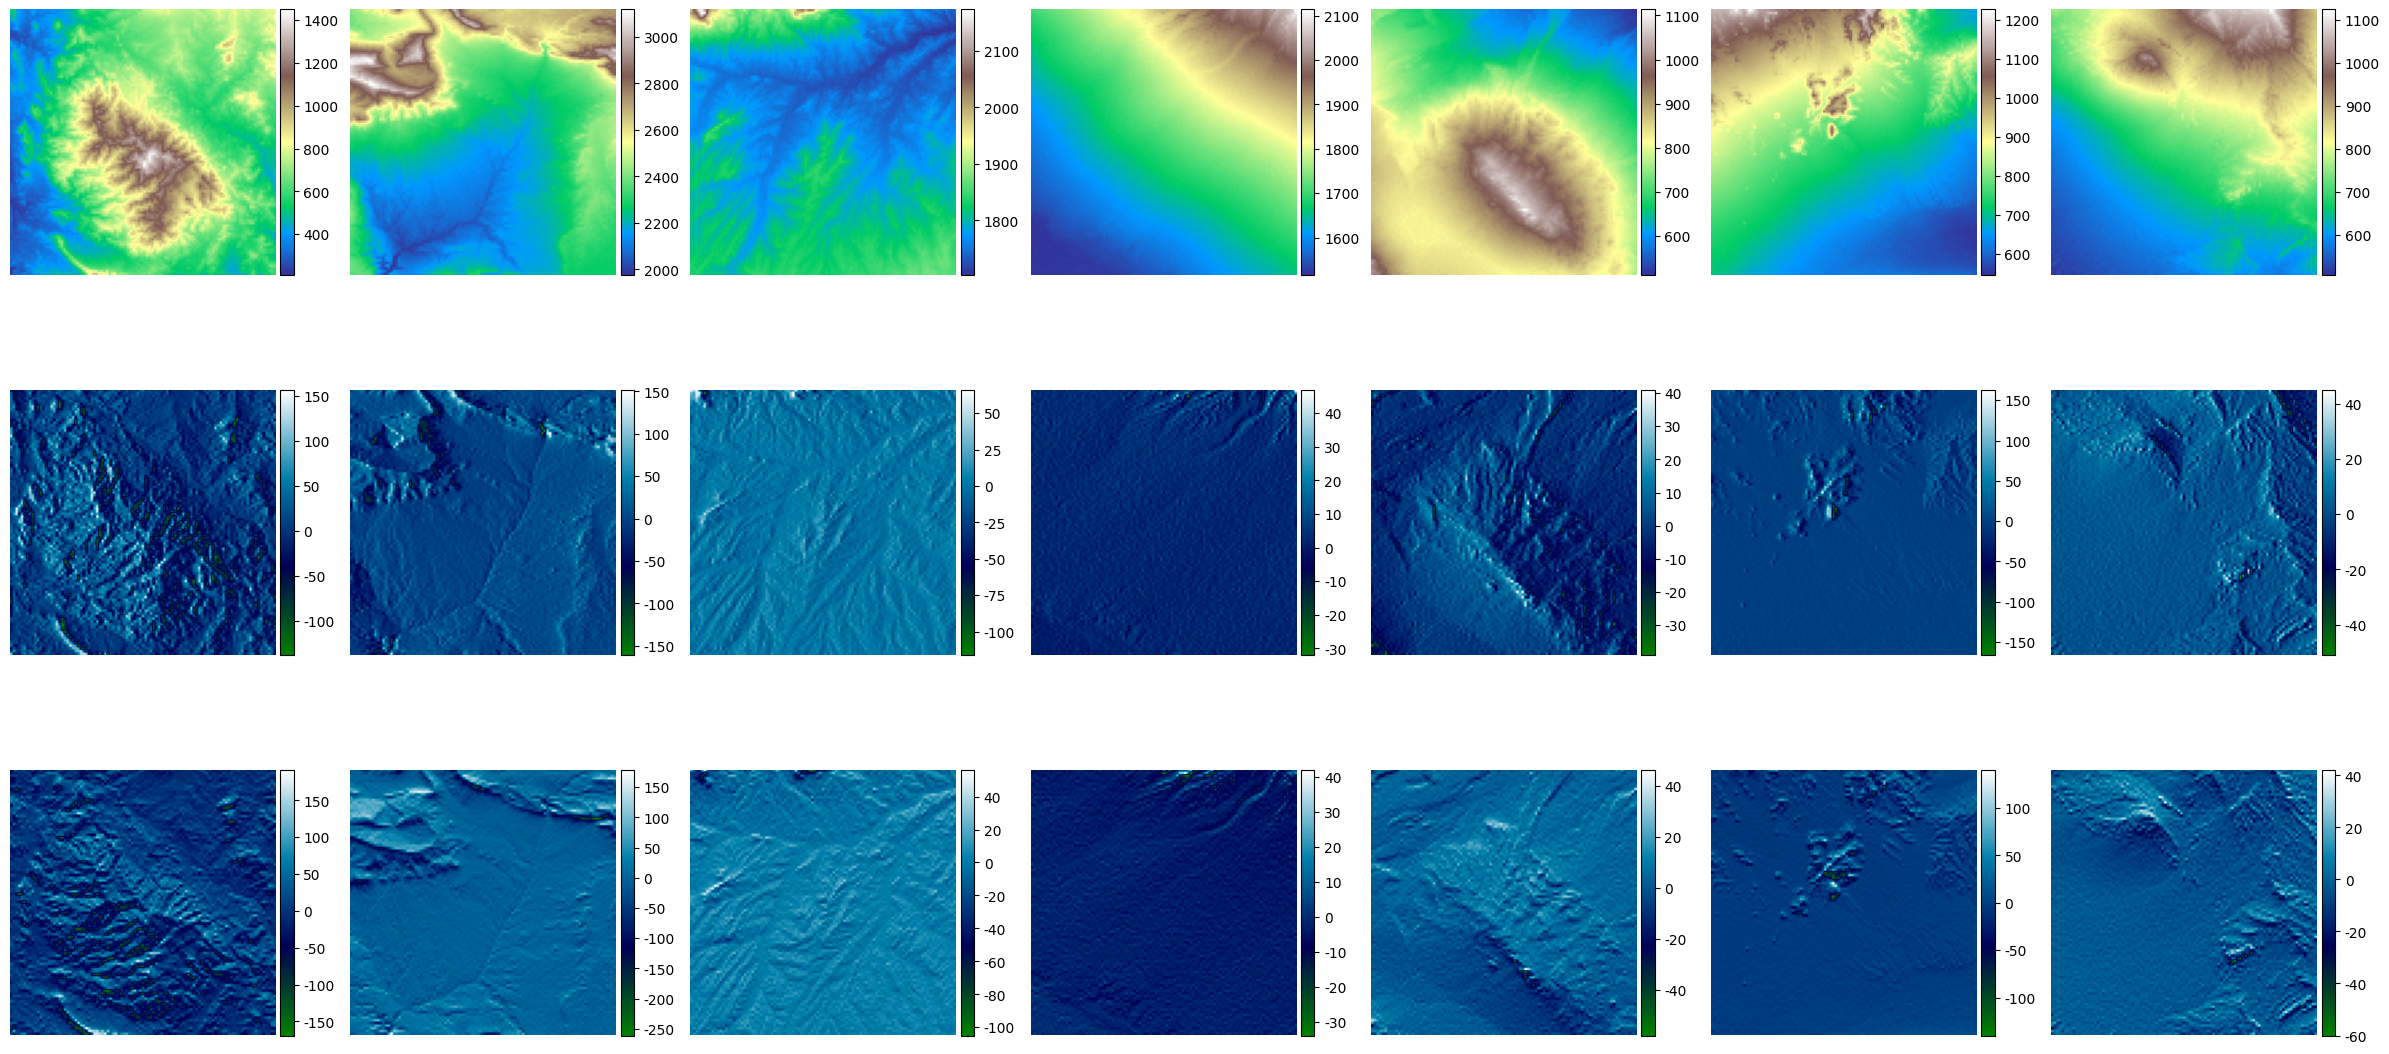

In [ ]:
fig, axes = plt.subplots(3,7, figsize=(30, 11))

# Individual key area plots
for ax_key, (key_name, key_info) in enumerate(key_data.items()):  
    print(key_info['data'].shape)
    grad_x, grad_y = height_to_slopes(key_info["data"])
    grad_x = grad_x[:-1, :]
    grad_y = grad_y[:, :-1]
    show(key_info["data"], transform=key_info["transform"], ax=axes[0, ax_key], cmap="terrain")
    show(grad_x, transform=key_info["transform"], ax=axes[1, ax_key], cmap="ocean")
    show(grad_y, transform=key_info["transform"], ax=axes[2, ax_key], cmap="ocean")
    
for key, ax in enumerate(axes.flatten()):

    # Make the colorbar proportionate to the plot
    divider = make_axes_locatable(ax)
    pos = "right"
    cax = divider.append_axes(pos, size="5%", pad=0.05)
    im = ax.images[0]
    cbar = plt.colorbar(im, cax=cax, orientation='vertical' if pos in ['left', 'right'] else 'horizontal')
    
    # if key != 7:
    #     cbar.set_ticks(np.linspace(im.get_array().min(), im.get_array().max(), 5))
    
    # Adjust tick label rotation and alignment based on position
    if pos in ['left', 'right']:
        cbar.ax.tick_params(labelrotation=0)  # Horizontal ticks
        cbar.ax.yaxis.set_ticks_position('left' if pos == 'left' else 'right')  # Position ticks on left or right
        cbar.ax.yaxis.set_label_position('left' if pos == 'left' else 'right')  # Position colorbar label on left or right
    else:
        cbar.ax.tick_params(labelrotation=90)  # Vertical ticks
        cbar.ax.xaxis.set_ticks_position('bottom' if pos == 'bottom' else 'top')  # Position ticks on top or bottom
        cbar.ax.xaxis.set_label_position('bottom' if pos == 'bottom' else 'top')  # Position colorbar label on top or bottom

    # Format tick labels as integers
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{int(val)}'))
    cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{int(val)}'))
    
    ax.axis('off')




# plot outputs

In [ ]:
run_folder = os.path.join("..", "results", "run_multi_input")
data_folder = os.path.join("..", "data")
for key_name in key_areas:
    image = key_data[key_name]['data']
    wfc = WaveFunctionCollapse([image], (2,2,2))
    save_path = os.path.join(run_folder, os.path.splitext(key_name)[0], 'wfc_state')
    wfc.load(save_path)
   
    outputs_path = glob.glob(os.path.join(run_folder, os.path.splitext(key_name)[0], 'wfc_out*.npy'))
    key_data[key_name]['outs'] = [np.load(f) for f in outputs_path]
    


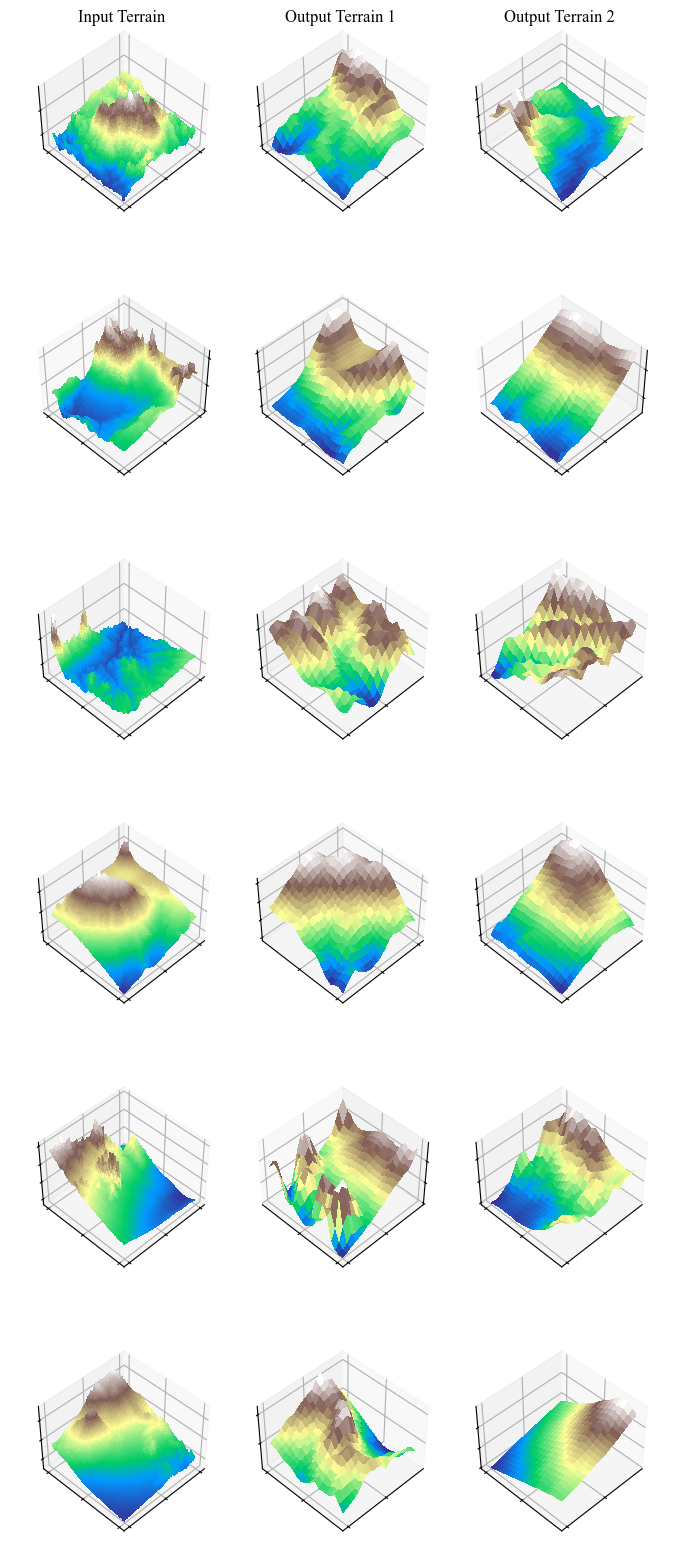

In [67]:
fig, axes = plt.subplots(6, 3, figsize= (8, 20))

for ax in axes.flatten():
    ax.set_axis_off()

i = 0
for key_name in key_areas:
    terrain = key_data[key_name]['data']
    outs = key_data[key_name]['outs'][:2]
    
    outs = [slopes_to_height(o[...,0], o[..., 1]) for o in outs]
    if len(outs) != 0:
        for j, im in enumerate([terrain, outs[0], outs[1]]):
            ax = fig.add_subplot(6, 3, 3*i + j + 1, projection='3d')

            x = -np.arange(im.shape[0]) 
            y = np.arange(im.shape[1])
            X, Y = np.meshgrid(x, y)
            ax.plot_surface(X, Y, im, cmap='terrain', rstride=1, cstride=1, linewidth=0, antialiased=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])
            if i == 0:
                if j == 0:
                    ax.set_title("Input Terrain")
                elif j == 1:
                    ax.set_title("Output Terrain 1")
                elif j == 2:
                    ax.set_title("Output Terrain 2")
                
            if i == 1 and j == 2:
                azim = -45
            elif i == 3 and j in [0, 1]:
                azim = -135
            elif i == 4 and j == 1:
                azim = -45
            elif i == 1 and j == 0:
                azim = 135
            else:
                azim = 45
            ax.view_init(elev=45, azim=azim)

        i += 1